In [1]:
from google.colab import drive
drive.mount('/content/drive') # mount 를 여기에 해줘

import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks")

from multiclass_functions1 import * # all
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

DEVICE =  "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)


Mounted at /content/drive
cuda
cuda


In [2]:
BATCH_SIZE = 32
LR = 1e-3
EPOCH = 5
criterion = nn.CrossEntropyLoss()
new_model_train = True
model_type = "CNN_deep"
dataset = "STL10"

save_model_path = f"/content/drive/MyDrive/Colab Notebooks/results/{model_type}_{dataset}.pt"

In [4]:
transform = transforms.ToTensor()
train_DS = datasets.STL10(root = '/content/drive/MyDrive/Colab Notebooks/data', split='train', download=True, transform=transform)
test_DS = datasets.STL10(root = '/content/drive/MyDrive/Colab Notebooks/data', split='test', download=True, transform=transform)

train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 2640397119/2640397119 [05:13<00:00, 8429159.68it/s]


Extracting /content/drive/MyDrive/Colab Notebooks/data/stl10_binary.tar.gz to /content/drive/MyDrive/Colab Notebooks/data
Files already downloaded and verified


(5000, 3, 96, 96)
(8000, 3, 96, 96)
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
torch.Size([32, 3, 96, 96])
deer


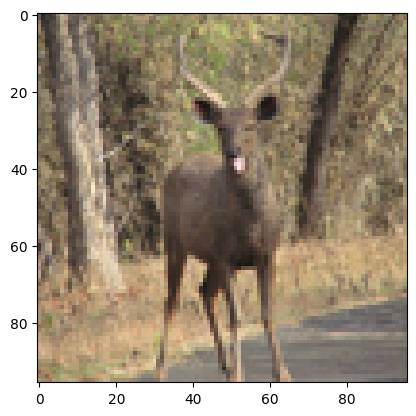

In [6]:
from itertools import permutations
print(train_DS.data.shape) # 개행열체
print(test_DS.data.shape)

print(train_DS.classes)

x_batch, y_batch=next(iter(test_DL)) # 개체행열로 바뀜
print(x_batch.shape)
plt.imshow(x_batch[0].permute(1,2,0)) # imshow 는 행열체로 바꿔줘야한다
print(test_DS.classes[y_batch[0]])

In [12]:
class CNN_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(nn.Conv2d(3,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
                                         nn.Conv2d(32,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU())
        self.Maxpool1 = nn.MaxPool2d(2)

        self.conv_block2 = nn.Sequential(nn.Conv2d(32,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU())
        self.Maxpool2 = nn.MaxPool2d(2)

        self.conv_block3 = nn.Sequential(nn.Conv2d(64,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU())
        self.Maxpool3 = nn.MaxPool2d(2)

        self.classifier = nn.Sequential(nn.Linear(128*12*12,512),
                                        nn.Linear(512,10))

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.Maxpool1(x)
        x = self.conv_block2(x)
        x = self.Maxpool2(x)
        x = self.conv_block3(x)
        x = self.Maxpool3(x)
        # print(x.shape)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

In [13]:
exec(f"model = {model_type}().to(DEVICE)")
print(model)
x_batch, _ = next(iter(train_DL))
print(model(x_batch.to(DEVICE)).shape)

CNN_deep(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=

Epoch: 1, train loss: 1.657
--------------------
Epoch: 2, train loss: 1.394
--------------------
Epoch: 3, train loss: 1.268
--------------------
Epoch: 4, train loss: 1.187
--------------------
Epoch: 5, train loss: 1.127
--------------------


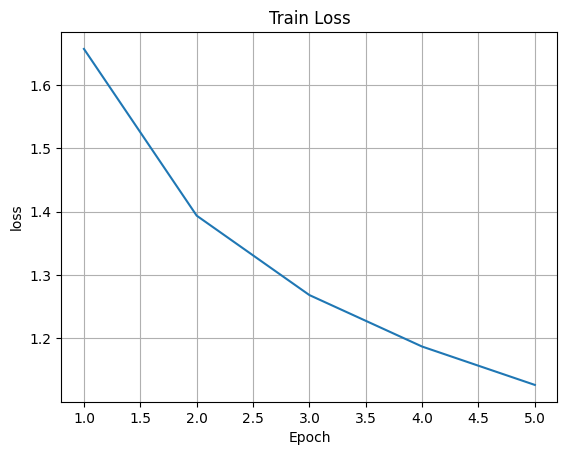

In [18]:
if new_model_train:

    optimizer = optim.Adam(model.parameters(), lr = LR)
    loss_history = Train(model, train_DL, criterion, optimizer, EPOCH)

    torch.save(model.state_dict(), save_model_path)

    plt.plot(range(1,EPOCH+1),loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title("Train Loss")
    plt.grid()

In [21]:
load_model = CNN_deep().to(DEVICE)
load_model.load_state_dict(torch.load(save_model_path, map_location=DEVICE))

<All keys matched successfully>

In [22]:
Test(load_model, test_DL)
print(count_params(load_model))

Test Accuracy: 55.675 (55.675 %)
9915626


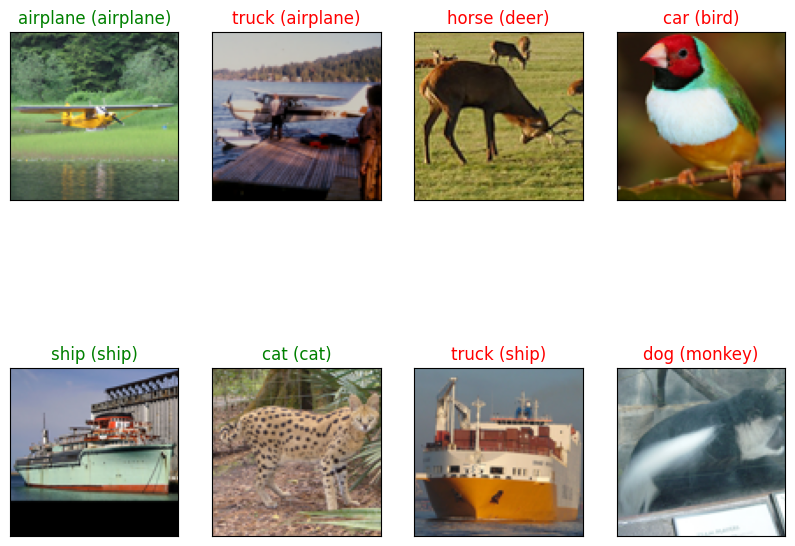

In [23]:
Test_plot(load_model, test_DL)